<a href="https://colab.research.google.com/github/Annie-Yeeun-Jang/Plant_disease_classification/blob/master/DenseNet_freeze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D, Activation, Dropout, Dense
from keras.optimizers import Adam
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.applications import DenseNet121

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
dst_path = '/content/gdrive/My Drive/dataset_split_aug'
# 경로 지정
import os
os.chdir('/content/gdrive/My Drive/dataset_split_aug')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# 전체 train 데이터에 이미지 노이즈 주기
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = os.path.join(dst_path, 'train')
validation_dir = os.path.join(dst_path, 'validation')
test_dir = os.path.join(dst_path, 'test')

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   zoom_range=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(64,64),
                                                    batch_size=64,
                                                    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(64,64),
                                                        batch_size=64,
                                                        class_mode='categorical')

Found 30748 images belonging to 33 classes.
Found 7989 images belonging to 33 classes.


DenseNet 모델 구성

In [ ]:
SIZE=64
N_ch=3

In [ ]:
def build_densenet():
    densenet = DenseNet121(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = densenet(x)
    for layer in densenet.layers[:-114]:
      layer.trainable = False
    for layer in densenet.layers:
      print(layer, layer.trainable)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(33,activation = 'softmax', name='root')(x)
 

    # model
    model = Model(input,output)
    
    optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

In [ ]:
model = build_densenet()
model.summary()

29089792/29084464 [==============================] - 1s 0us/step
<keras.engine.input_layer.InputLayer object at 0x7f2390bd9b38> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7f23d01ba4a8> False
<keras.layers.convolutional.Conv2D object at 0x7f23d01ba3c8> False
<keras.layers.normalization.BatchNormalization object at 0x7f23e55e7080> False
<keras.layers.core.Activation object at 0x7f23e55e72b0> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7f2391847940> False
<keras.layers.pooling.MaxPooling2D object at 0x7f2391847668> False
<keras.layers.normalization.BatchNormalization object at 0x7f2391847e80> False
<keras.layers.core.Activation object at 0x7f23909b5278> False
<keras.layers.convolutional.Conv2D object at 0x7f23909d0e80> False
<keras.layers.normalization.BatchNormalization object at 0x7f239098ce10> False
<keras.layers.core.Activation object at 0x7f23909919e8> False
<keras.layers.convolutional.Conv2D object at 0x7f23909a6be0> False
<keras.layers.merge.Concate

모델 실행

In [ ]:
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)

MODEL_SAVE_FOLDER_PATH='/content/gdrive/My Drive/model_save/dense_freeze/'
model_path = MODEL_SAVE_FOLDER_PATH + '{epoch:02d}-{val_loss:.4f}.hdf5'

checkpoint= ModelCheckpoint(filepath=model_path,monitor='val_accuracy',verbose=1, save_best_only=True)
earlystop=EarlyStopping(patience=10)

my_callbacks = [earlystop,checkpoint,annealer]

In [ ]:
dense = model.fit_generator(train_generator,
                               epochs=50,
                               validation_data=validation_generator,
                               callbacks=my_callbacks)

Epoch 1/50
481/481 [==============================] - 10218s 21s/step - loss: 3.4562 - accuracy: 0.1939 - val_loss: 1.8261 - val_accuracy: 0.4540

Epoch 00001: val_accuracy improved from -inf to 0.45400, saving model to /content/gdrive/My Drive/model_save/dense_freeze/01-1.8261.hdf5
Epoch 2/50
481/481 [==============================] - 122s 254ms/step - loss: 2.1080 - accuracy: 0.4256 - val_loss: 1.3258 - val_accuracy: 0.5414

Epoch 00002: val_accuracy improved from 0.45400 to 0.54137, saving model to /content/gdrive/My Drive/model_save/dense_freeze/02-1.3258.hdf5
Epoch 3/50
481/481 [==============================] - 120s 249ms/step - loss: 1.5473 - accuracy: 0.5516 - val_loss: 1.1283 - val_accuracy: 0.6165

Epoch 00003: val_accuracy improved from 0.54137 to 0.61647, saving model to /content/gdrive/My Drive/model_save/dense_freeze/03-1.1283.hdf5
Epoch 4/50
481/481 [==============================] - 120s 250ms/step - loss: 1.2495 - accuracy: 0.6279 - val_loss: 0.9706 - val_accuracy: 0.6

In [ ]:
model.save('/content/gdrive/My Drive/model_save/dense_freeze/DenseNet_freeze.h5')

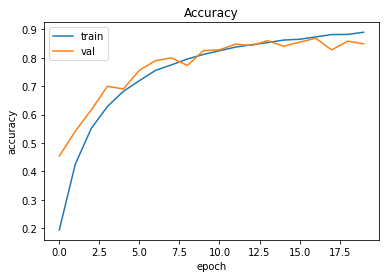

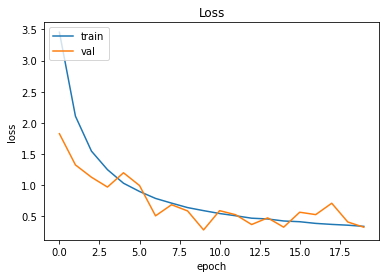

In [ ]:
# accuracy plot 
plt.plot(dense.history['accuracy'])
plt.plot(dense.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# loss plot
plt.plot(dense.history['loss'])
plt.plot(dense.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

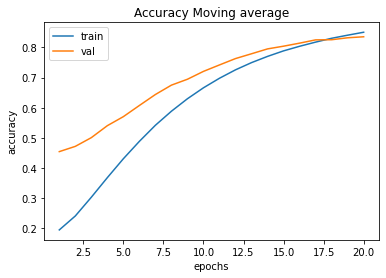

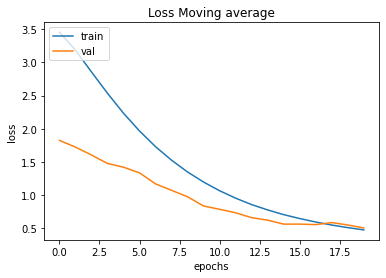

In [ ]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history_train = smooth_curve(dense.history['accuracy'])
smooth_mae_history_val = smooth_curve(dense.history['val_accuracy'])
plt.plot(range(1, len(smooth_mae_history_train) + 1), smooth_mae_history_train)
plt.plot(range(1, len(smooth_mae_history_val) + 1), smooth_mae_history_val)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Accuracy Moving average')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


plt.plot(smooth_curve(dense.history['loss']))
plt.plot(smooth_curve(dense.history['val_loss']))
plt.title('Loss Moving average')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()